In [ ]:
# pip install sagemaker

In [ ]:
# pip install s3fs 

In [ ]:
# pip install boto3

In [ ]:
import sagemaker
import boto3
from sagemaker.amazon.amazon_estimator import get_image_uri 
from sagemaker.session import s3_input, Session
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import display
from time import gmtime, strftime
from sagemaker.predictor import csv_serializer

In [ ]:
bucket = 'modeltestbucket' # <--- CHANGE THIS VARIABLE TO A UNIQUE NAME FOR YOUR BUCKET
my_region = boto3.session.Session().region_name # set the region of the instance
print(my_region)


us-east-1


# I have already manually created bucket in aws, if not we can also  create bucket here

In [ ]:
# bucket_name = 'modeltestbucket' # <--- CHANGE THIS VARIABLE TO A UNIQUE NAME FOR YOUR BUCKET
# s3 = boto3.resource('s3')
# try:
#     if  my_region == 'us-east-1':
#       s3.create_bucket(Bucket=bucket_name)
#     else: 
#       s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={ 'LocationConstraint': 'us-west-2' })
#     print('S3 bucket created successfully')
# except Exception as e:
#     print('S3 error: ',e)

In [ ]:
# setting the model path or output path in our s3 bucket where we will store our formatted files
bucket_name = 'modeltestbucket'
prefix = 'xgboost-as-a-built-in-algo'
output_path ='s3://{}/{}/output'.format(bucket_name, prefix)
print(output_path)

s3://modeltestbucket/xgboost-as-a-built-in-algo/output


# uploading/downloading of files into or from s3 bucket

# Loading CSV File From S3 Bucket Using URI

In [ ]:
bucket='modeltestbucket'

path1='s3://modeltestbucket/train-1.csv'
path2='s3://modeltestbucket/test-2.csv'

train=pd.read_csv(path1)
test=pd.read_csv(path2)

train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
train.shape, test.shape

((1460, 81), (1459, 80))

# Store the train and test data in our s3 bucket

In [ ]:
import pandas as pd
import urllib
try:
    dataset_train = pd.read_csv("C:/Users/santh/S3 Bucket to Sage Maker-AWS/Data/train-1.csv")
    dataset_test = pd.read_csv("C:/Users/santh/S3 Bucket to Sage Maker-AWS/Data/test-2.csv")
    print('Success: Data loaded into dataframe.')
#     data.head()
except Exception as e:
    print('Data load error: ',e)


Success: Data loaded into dataframe.


In [ ]:
dataset_train.shape, dataset_test.shape

((1460, 81), (1459, 80))

# Loading CSV File From S3 Bucket Using Boto3

In [ ]:
conn=boto3.client('s3')
list_buckets = conn.list_buckets()
 
for bucket in list_buckets['Buckets']:
    print(bucket['Name'])

modeltestbucket


In [ ]:
obj = conn.get_object(Bucket='modeltestbucket', Key='train-1.csv')
obj['Body'].read().decode('utf-8')

In [ ]:
obj2 = conn.get_object(Bucket='modeltestbucket', Key='test-2.csv')
obj2['Body'].read().decode('utf-8') 

In [ ]:
conn.download_file(Filename='train_downloadfile.csv', Bucket='modeltestbucket', Key='train-1.csv')

In [ ]:
conn.download_file(Filename='test_downloadfile.csv', Bucket='modeltestbucket', Key='test-2.csv')

# we will keep dataset_test aside for the modelbuilding. But we will do data cleaning both on train and test data.

# Train Data PreProcessing

Dealing with null values

In [ ]:
train['LotFrontage']=train['LotFrontage'].fillna(train['LotFrontage'].mean())
train.drop(['Alley'],axis=1,inplace=True)
train['BsmtCond']=train['BsmtCond'].fillna(train['BsmtCond'].mode()[0])
train['BsmtQual']=train['BsmtQual'].fillna(train['BsmtQual'].mode()[0])
train['FireplaceQu']=train['FireplaceQu'].fillna(train['FireplaceQu'].mode()[0])
train['GarageType']=train['GarageType'].fillna(train['GarageType'].mode()[0])
train.drop(['GarageYrBlt'],axis=1,inplace=True)
train['GarageFinish']=train['GarageFinish'].fillna(train['GarageFinish'].mode()[0])
train['GarageQual']=train['GarageQual'].fillna(train['GarageQual'].mode()[0])
train['GarageCond']=train['GarageCond'].fillna(train['GarageCond'].mode()[0])
train.drop(['PoolQC','Fence','MiscFeature'],axis=1,inplace=True)
train.drop(['Id'],axis=1,inplace=True)
train['MasVnrType']=train['MasVnrType'].fillna(train['MasVnrType'].mode()[0])
train['MasVnrArea']=train['MasVnrArea'].fillna(train['MasVnrArea'].mode()[0])
train['BsmtExposure']=train['BsmtExposure'].fillna(train['BsmtExposure'].mode()[0])
train['BsmtFinType2']=train['BsmtFinType2'].fillna(train['BsmtFinType2'].mode()[0])
train.dropna(inplace=True)

In [ ]:
train.shape, test.shape

((1422, 75), (1459, 80))

# Convert categorical to numerical data

In [ ]:
from sklearn.preprocessing import label_binarize,LabelEncoder
cat_bf=train.select_dtypes(exclude=np.number)
cat_bf.columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

In [ ]:
lb=LabelEncoder()
for i in cat_bf.columns:
    train[i]=lb.fit_transform(np.array(train[i]).reshape(-1,1))

D:\Anaconda\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
train.to_csv('formattedtrain.csv',',')  # saving this dataframe to csv



<AxesSubplot:>

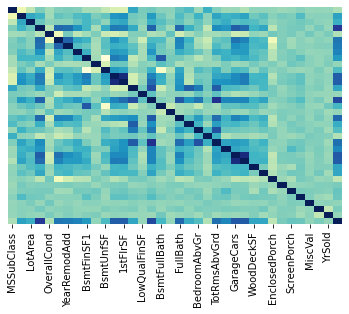

In [ ]:
sns.heatmap(train.corr(),yticklabels=False,cbar=False,cmap='YlGnBu')

# Uploading this Cleaned Dataset to s3 bucket

In [ ]:
conn.upload_file(Bucket='modeltestbucket', 
               Filename='formattedtrain.csv', 
               Key='/formattedtrain.csv')